In [2]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import pearsonr
from scipy.io import savemat
from utils import daily_blocks, extract_all_licks, get_tone_response_df, block_stim_evoke_response
plt.rcParams['axes.facecolor'] = 'white'
outcome_list = ['Hit', 'Miss', 'FA', 'CR']
mouse_names = ['jl009', 'fz017', 'fz009', 'fz006']
data_paths = ["Z:/Jenni/jl009/behavimaging.mat",
             "W:/Jenni/fz017/behavimaging.mat",
             "Y:/Jenni/fz009/behavimaging.mat",
             "Y:/sarah/fz006/behavimaging.mat"]
disks = ['Z', 'W', 'Y', 'Y']

In [3]:
mouse_id = 0
mouse_name = mouse_names[mouse_id]
disk = disks[mouse_id]

# load data

In [4]:
data_path = "{}_behavimaging.mat".format(mouse_name)
mat = scipy.io.loadmat(data_path)
data = mat['behavimaging']
nBlocks = data.shape[-1]
nDays = data[0, -1]['day'][0][0]

# save all figures(for each outcome)

In [5]:
from utils import daily_blocks, block_stim_evoke_response
day = 1
for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for i in iblocks:
            block = data[0, i]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, normalize=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_firstlicks = np.hstack(daily_firstlicks)
        daily_alllicks = np.vstack(daily_alllicks)

        print('day {} spk shape: {}'.format(day, daily_responses.shape))
        print('day {} behavior shape: {}'.format(day, daily_outcomes.shape))
        print('day {} alllick shape: {}'.format(day, daily_alllicks.shape))
        
        NN = daily_responses.shape[1]
        
        # from scipy.stats import pearsonr
        daily_spks = daily_responses.transpose(1, 0, 2)
        daily_spks = daily_spks.reshape(NN, -1)
        avg_resp = np.mean(daily_spks, axis=0) # ntrials x 75
        corr = np.zeros(NN)
        for i in range(NN):
            corr[i] = pearsonr(avg_resp, daily_spks[i])[0]
        isort = np.argsort(corr)
        
        outcome_index = 1
        for outcome_index in range(1,5):
            ioutcome = np.where(daily_outcomes == outcome_index)[0]
            resp = daily_responses[ioutcome]
            lick = daily_alllicks[ioutcome].reshape(-1)
            resp = resp.transpose(1, 0, 2)
            resp = resp.reshape(NN, -1)
            resp = resp[isort]
            NT = resp.shape[-1]
            cue = np.zeros(NT)
            out = np.zeros(NT)
            flick = np.zeros(NT)
            for k, v in enumerate(ioutcome):
                cue[30+75*k] = daily_cues[v]
                out[30+75*k] = daily_outcomes[v]
                if daily_firstlicks[k] >= 0:
                    flick[75*k + int(daily_firstlicks[v])] = 1
                resp[:, (75*k-1):(75*k+1)] = 0
            figw = max(int(len(ioutcome)*10/15), 20)
            f, (a0, a1, a2, a3, a4) = plt.subplots(5, 1, gridspec_kw={'height_ratios': [3, 1, 2, 1, 1]}, figsize=(figw,10))
            f.set_facecolor("white")
            im1 = a0.imshow(resp, vmin=-0.5, vmax=0.5, cmap='bwr', aspect='auto') # magma
            a0.set_xlabel('frames')
            a0.set_ylabel('neuron')
            x = np.arange(NT)
            y = resp.mean(axis=0)
            tmin = 0
            tmax = NT
            a1.plot(x, lick, label='all lick')
            a1.set_xlim([tmin, tmax])
            a1.plot(x, flick, label='first lick')
            a1.legend(loc=1)
            a2.plot(x, y)
            idx = np.where(cue > 0)[0]
            a2.scatter(x[idx], y[idx], c='red', label='cue onset')
            a2.legend(loc=1)
            idx = np.where(flick>0)
            # a2.scatter(x[idx], y[idx], c='orange', label='first lick')
            a2.legend(loc=1)
            for k, v in enumerate(ioutcome):
                a1.axvline(75*k, alpha=0.2, linestyle='--')
            a2.set_xlim([tmin, tmax])
            a2.set_title('average activity')
            a3.plot(np.arange(NT), cue)
            a3.set_xlim([tmin, tmax])
            a3.set_ylim([0, 4])
            a3.set_title('cue')
            a4.plot(np.arange(NT), out)
            a4.set_xlim([tmin, tmax])
            a4.set_title('outcome')
            a4.set_ylim([0, 4])
            a0.set_title('day {}'.format(day))
#             a4.plot(np.arange(NT), flick)
#             a4.set_xlim([tmin, tmax])
#             a4.set_title('first lick')
            plt.tight_layout()
            fig_save_path = os.path.join('figures', 'stim-evoke-response_{}_day-{}_{}'.format(mouse_name, day, outcome_list[outcome_index-1]))
            plt.savefig(fig_save_path, dpi=100)
            plt.close()

TypeError: only size-1 arrays can be converted to Python scalars

# average response(per day)

In [12]:
day = 1
for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    plt.figure(figsize=(20, 10))
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for i in iblocks:
            block = data[0, i]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, normalize=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_firstlicks = np.hstack(daily_firstlicks)
        daily_alllicks = np.vstack(daily_alllicks)

        print('day {} spk shape: {}'.format(day, daily_responses.shape))
        print('day {} behavior shape: {}'.format(day, daily_outcomes.shape))
        print('day {} alllick shape: {}'.format(day, daily_alllicks.shape))

        NN = daily_responses.shape[1]

        # from scipy.stats import pearsonr
        daily_spks = daily_responses.transpose(1, 0, 2)
        daily_spks = daily_spks.reshape(NN, -1)
        avg_resp = np.mean(daily_spks, axis=0) # ntrials x 75
        corr = np.zeros(NN)
        for i in range(NN):
            corr[i] = pearsonr(avg_resp, daily_spks[i])[0]
        isort = np.argsort(corr)
        for outcome_index in range(1,5):
            # hit responses
            ioutcome = np.where(daily_outcomes == outcome_index)[0]
            resp = daily_responses[ioutcome]
            lick = daily_alllicks[ioutcome]
            NT = resp.shape[-1]
            resp = resp.reshape(-1, NT)
            resp = np.mean(resp, axis=0)
            flick = np.zeros(NT)
            plt.subplot(2,4,outcome_index)
            x = np.arange(NT)
            plt.plot(x, resp)
            plt.title(outcome_list[outcome_index-1])
            plt.ylabel('df/f')
            plt.subplot(2,4,4+outcome_index)
            plt.imshow(lick, cmap='binary')
            plt.xlabel('frame')
            plt.ylabel('trial')
        plt.suptitle('day {}'.format(day))
        fig_save_path = os.path.join('figures',  'avg_stim-evoke-response_{}_day-{}'.format(mouse_name, day))
        plt.savefig(fig_save_path, dpi=100)
        plt.close()

day 1 spk shape: (100, 361, 75)
day 1 behavior shape: (100,)
day 1 alllick shape: (100, 75)
day 2 spk shape: (100, 312, 75)
day 2 behavior shape: (100,)
day 2 alllick shape: (100, 75)
day 5 spk shape: (300, 159, 75)
day 5 behavior shape: (300,)
day 5 alllick shape: (300, 75)


<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

## average response based on pre-cue lick rate

In [43]:
day = 1
for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    plt.figure(figsize=(20, 10))
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for i in iblocks:
            block = data[0, i]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, normalize=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_firstlicks = np.hstack(daily_firstlicks)
        daily_alllicks = np.vstack(daily_alllicks)

#         print('day {} spk shape: {}'.format(day, daily_responses.shape))
#         print('day {} behavior shape: {}'.format(day, daily_outcomes.shape))
#         print('day {} alllick shape: {}'.format(day, daily_alllicks.shape))

        NN = daily_responses.shape[1]

        # from scipy.stats import pearsonr
        daily_spks = daily_responses.transpose(1, 0, 2)
        daily_spks = daily_spks.reshape(NN, -1)
        avg_resp = np.mean(daily_spks, axis=0) # ntrials x 75
        for outcome_index in range(1,5):
            # hit responses
            ioutcome = np.where(daily_outcomes == outcome_index)[0]
            resp = daily_responses[ioutcome]
            NT = resp.shape[-1]
            print(resp.shape)


            lick = daily_alllicks[ioutcome]
            n_prelicks = np.sum(lick[:, :15], axis=1)
            lick_idx = np.where(n_prelicks == 0)[0]
            resp_lick = resp[lick_idx].reshape(-1, NT)
            resp_lick = np.mean(resp_lick, axis=0)
            nolick_idx = np.where(n_prelicks != 0)[0]
            resp_nolick = resp[nolick_idx].reshape(-1, NT)
            resp_nolick = np.mean(resp_nolick, axis=0)
            lick_sort = np.argsort(n_prelicks)
            lick = lick[lick_sort]
            
            resp = resp.reshape(-1, NT)
            all_resp = np.mean(resp, axis=0)

            plt.subplot(2,4,outcome_index)
            x = np.arange(NT)
            plt.plot(x, resp_lick, label='with pre lick')
            plt.plot(x, resp_nolick, label='no pre lick')
            plt.ylim([-0.1, 0.15])
            # plt.plot(x, all_resp, label='all', color='black', linestyle='--')
            plt.title(outcome_list[outcome_index-1])
            plt.legend()
            plt.ylabel('df/f')
            plt.subplot(2,4,4+outcome_index)
            plt.imshow(lick, cmap='binary')
            plt.xlabel('frame')
            plt.ylabel('trial')
        plt.suptitle('day {}'.format(day))
        fig_save_path = os.path.join('figures',  'avg_stim-evoke-response-prelickornot_{}_day-{}'.format(mouse_name, day))
        plt.savefig(fig_save_path, dpi=100)
        plt.close()

(72, 175, 75)
(78, 175, 75)
(69, 175, 75)
(81, 175, 75)
(90, 141, 75)
(60, 141, 75)
(82, 141, 75)
(68, 141, 75)
(104, 205, 75)
(46, 205, 75)
(69, 205, 75)
(81, 205, 75)
(66, 139, 75)
(34, 139, 75)
(51, 139, 75)
(49, 139, 75)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(98, 158, 75)
(2, 158, 75)
(77, 158, 75)
(23, 158, 75)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(130, 169, 75)
(20, 169, 75)
(102, 169, 75)
(48, 169, 75)
(72, 171, 75)
(28, 171, 75)
(50, 171, 75)
(50, 171, 75)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(63, 187, 75)
(37, 187, 75)
(47, 187, 75)
(53, 187, 75)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(127, 198, 75)
(23, 198, 75)
(89, 198, 75)
(61, 198, 75)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(113, 180, 75)
(37, 180, 75)
(56, 180, 75)
(94, 180, 75)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

# average response (per outcome)

In [5]:
n_valid_days = 0
for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        n_valid_days += 1

In [7]:
# per outcome
day = 1
for outcome_index in range(1,5):
    iday = 0
    f, axs = plt.subplots(2, n_valid_days, gridspec_kw={'width_ratios': np.ones(n_valid_days)}, figsize=(int(5*n_valid_days), 5))
    for day in range(1, nDays+1):
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            iday += 1
            daily_cues = []
            daily_outcomes = []
            daily_responses = []
            daily_firstlicks = []
            daily_alllicks = []
            daily_nblock = []
            for i in iblocks:
                block = data[0, i]
                # normalize doesn't have much effect on the result, so set it to False
                cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, normalize=False)
                daily_cues.append(cues)
                daily_outcomes.append(outcomes)
                daily_responses.append(stim_resp)
                daily_firstlicks.append(firstlicks)
                daily_alllicks.append(alllicks)
                daily_nblock.append(block['block'][0][0] * np.ones(len(cues)))

            daily_cues = np.hstack(daily_cues)
            daily_outcomes = np.hstack(daily_outcomes)
            daily_responses = np.vstack(daily_responses)
            daily_firstlicks = np.hstack(daily_firstlicks)
            daily_alllicks = np.vstack(daily_alllicks)
            daily_nblock = np.hstack(daily_nblock)

            print('day {} spk shape: {}'.format(day, daily_responses.shape))
            print('day {} behavior shape: {}'.format(day, daily_outcomes.shape))
            print('day {} alllick shape: {}'.format(day, daily_outcomes.shape))

            NN = daily_responses.shape[1]

            # from scipy.stats import pearsonr
            daily_spks = daily_responses.transpose(1, 0, 2)
            daily_spks = daily_spks.reshape(NN, -1)
            avg_resp = np.mean(daily_spks, axis=0) # ntrials x 75

            # hit responses
            ioutcome = np.where(daily_outcomes == outcome_index)[0]
            resp = daily_responses[ioutcome]
            lick = daily_alllicks[ioutcome]
            nblock = daily_nblock[ioutcome].reshape(-1, 1)
            nblock = np.repeat(nblock, lick.shape[-1], axis=1)
            cue = daily_cues[i]
            NT = resp.shape[-1]
            resp = resp.reshape(-1, NT)
            resp = np.mean(resp, axis=0)
            # plt.subplot(2, n_valid_days, iday)
            x = np.arange(NT)
            axs[0, iday-1].plot(x, resp)
            axs[0, iday-1].set_title('day {}, {}'.format(day, outcome_list[outcome_index-1]))
            axs[0, iday-1].set_ylabel('df/f')
            axs[0, iday-1].set_xlim([0, 75])
            axs[0, iday-1].set_ylim([-0.05, 0.13])
            # plt.subplot(2, n_valid_days, iday+n_valid_days)
            axs[1, iday-1].imshow(lick*nblock, cmap='Greys', aspect="auto", vmin=0, vmax=3)
    fig_save_path = os.path.join('figures', 'avg_stim-evoke-response_{}_{}'.format(mouse_name, outcome_list[outcome_index-1]))
    plt.savefig(fig_save_path, dpi=100)
    plt.close()

day 1 spk shape: (300, 175, 75)
day 1 behavior shape: (300,)
day 1 alllick shape: (300,)
day 2 spk shape: (300, 141, 75)
day 2 behavior shape: (300,)
day 2 alllick shape: (300,)
day 3 spk shape: (300, 205, 75)
day 3 behavior shape: (300,)
day 3 alllick shape: (300,)
day 4 spk shape: (200, 139, 75)
day 4 behavior shape: (200,)
day 4 alllick shape: (200,)
day 5 spk shape: (200, 158, 75)
day 5 behavior shape: (200,)
day 5 alllick shape: (200,)
day 6 spk shape: (300, 169, 75)
day 6 behavior shape: (300,)
day 6 alllick shape: (300,)
day 7 spk shape: (200, 171, 75)
day 7 behavior shape: (200,)
day 7 alllick shape: (200,)
day 8 spk shape: (200, 187, 75)
day 8 behavior shape: (200,)
day 8 alllick shape: (200,)
day 9 spk shape: (300, 198, 75)
day 9 behavior shape: (300,)
day 9 alllick shape: (300,)
day 15 spk shape: (300, 180, 75)
day 15 behavior shape: (300,)
day 15 alllick shape: (300,)
day 1 spk shape: (300, 175, 75)
day 1 behavior shape: (300,)
day 1 alllick shape: (300,)
day 2 spk shape: (

# average response (PB or RL)

In [15]:
# per outcome
day = 1
for outcome_index in range(1,5):
    iday = 0
    f, axs = plt.subplots(2, n_valid_days, gridspec_kw={'width_ratios': np.ones(n_valid_days)}, figsize=(5*n_valid_days, 5))
    for day in range(1, nDays+1):
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            iday += 1
            daily_cues = []
            daily_outcomes = []
            daily_responses = []
            daily_firstlicks = []
            daily_alllicks = []
            for i in iblocks:
                block = data[0, i]
                # normalize doesn't have much effect on the result, so set it to False
                cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, normalize=False)
                daily_cues.append(cues)
                daily_outcomes.append(outcomes)
                daily_responses.append(stim_resp)
                daily_firstlicks.append(firstlicks)
                daily_alllicks.append(alllicks)

            daily_cues = np.hstack(daily_cues)
            daily_outcomes = np.hstack(daily_outcomes)
            daily_responses = np.vstack(daily_responses)
            daily_firstlicks = np.hstack(daily_firstlicks)
            daily_alllicks = np.vstack(daily_alllicks)

            print('day {} spk shape: {}'.format(day, daily_responses.shape))
            print('day {} behavior shape: {}'.format(day, daily_outcomes.shape))
            print('day {} alllick shape: {}'.format(day, daily_outcomes.shape))

            NN = daily_responses.shape[1]

            # from scipy.stats import pearsonr
            daily_spks = daily_responses.transpose(1, 0, 2)
            daily_spks = daily_spks.reshape(NN, -1)
            avg_resp = np.mean(daily_spks, axis=0) # ntrials x 75
            corr = np.zeros(NN)
            for i in range(NN):
                corr[i] = pearsonr(avg_resp, daily_spks[i])[0]
            # hit responses
            ioutcome = np.where(daily_outcomes == outcome_index)[0]
            iRL = np.where(daily_cues < 3)[0]
            iPB = np.where(daily_cues > 2)[0]
            iRL = np.intersect1d(ioutcome, iRL)
            iPB = np.intersect1d(ioutcome, iPB)
            rl_resp = daily_responses[iRL]
            NT = rl_resp.shape[-1]
            rl_resp = rl_resp.reshape(-1, NT)
            rl_resp = np.mean(rl_resp, axis=0)
            
            pb_resp = daily_responses[iPB]
            pb_resp = pb_resp.reshape(-1, NT)
            pb_resp = np.mean(pb_resp, axis=0)
            
            rl_lick = daily_alllicks[iRL]
            pb_lick = -1.0 * daily_alllicks[iPB]
            lick = np.vstack([rl_lick, pb_lick])
            # print(lick.shape, lick.min(), lick.max())
            # plt.subplot(2, n_valid_days, iday)
            x = np.arange(NT)
            axs[0, iday-1].plot(x, rl_resp, color='red', label='RL')
            axs[0, iday-1].plot(x, pb_resp, color='blue', label='PB')
            axs[0, iday-1].set_title('day {}, {}'.format(day, outcome_list[outcome_index-1]))
            axs[0, iday-1].set_ylabel('df/f')
            axs[0, iday-1].set_xlim([0, 75])
            axs[0, iday-1].set_ylim([-0.03, 0.1])
            axs[0, iday-1].legend(loc=1)
            # plt.subplot(2, n_valid_days, iday+n_valid_days)
            axs[1, iday-1].imshow(lick, cmap='bwr', aspect="auto", vmin=-1, vmax=1)
            axs[1, iday-1].set_xlabel('frame')
            axs[1, iday-1].set_ylabel('trial')
            axs[1, iday-1].set_xlim([0, 75])
    fig_save_path = os.path.join('figures','avg_stim-evoke-response_RLPB_{}_{}'.format(mouse_name, outcome_list[outcome_index-1]))
    plt.savefig(fig_save_path)
    plt.close()

day 1 spk shape: (100, 361, 75)
day 1 behavior shape: (100,)
day 1 alllick shape: (100,)
day 2 spk shape: (100, 312, 75)
day 2 behavior shape: (100,)
day 2 alllick shape: (100,)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


day 5 spk shape: (300, 159, 75)
day 5 behavior shape: (300,)
day 5 alllick shape: (300,)
day 1 spk shape: (100, 361, 75)
day 1 behavior shape: (100,)
day 1 alllick shape: (100,)
day 2 spk shape: (100, 312, 75)
day 2 behavior shape: (100,)
day 2 alllick shape: (100,)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


day 5 spk shape: (300, 159, 75)
day 5 behavior shape: (300,)
day 5 alllick shape: (300,)
day 1 spk shape: (100, 361, 75)
day 1 behavior shape: (100,)
day 1 alllick shape: (100,)
day 2 spk shape: (100, 312, 75)
day 2 behavior shape: (100,)
day 2 alllick shape: (100,)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


day 5 spk shape: (300, 159, 75)
day 5 behavior shape: (300,)
day 5 alllick shape: (300,)
day 1 spk shape: (100, 361, 75)
day 1 behavior shape: (100,)
day 1 alllick shape: (100,)
day 2 spk shape: (100, 312, 75)
day 2 behavior shape: (100,)
day 2 alllick shape: (100,)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


day 5 spk shape: (300, 159, 75)
day 5 behavior shape: (300,)
day 5 alllick shape: (300,)


# area under curve

start


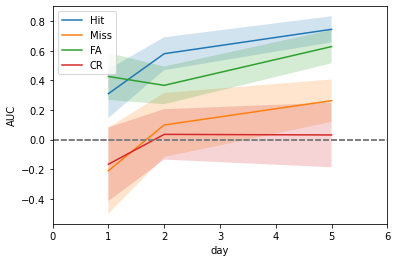

In [20]:
day = 1
print('start')
fig = plt.figure(figsize=(6,4))
fig.patch.set_facecolor('white')
for outcome_index in range(1,5):
    iday = 0
    areas = []
    days = []
    bandwidth = []
    # f, axs = plt.subplots(2, n_valid_days, gridspec_kw={'width_ratios': np.ones(n_valid_days)}, figsize=(5*n_valid_days, 5))
    for day in range(1, nDays+1):
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            iday += 1
            daily_cues = []
            daily_outcomes = []
            daily_responses = []
            daily_firstlicks = []
            daily_alllicks = []
            for i in iblocks:
                block = data[0, i]
                # normalize doesn't have much effect on the result, so set it to False
                cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, normalize=False)
                daily_cues.append(cues)
                daily_outcomes.append(outcomes)
                daily_responses.append(stim_resp)
                daily_firstlicks.append(firstlicks)
                daily_alllicks.append(alllicks)

            daily_cues = np.hstack(daily_cues)
            daily_outcomes = np.hstack(daily_outcomes)
            daily_responses = np.vstack(daily_responses)
            daily_firstlicks = np.hstack(daily_firstlicks)
            daily_alllicks = np.vstack(daily_alllicks)

            NN = daily_responses.shape[1]

            # from scipy.stats import pearsonr
            daily_spks = daily_responses.transpose(1, 0, 2)
            daily_spks = daily_spks.reshape(NN, -1)
            avg_resp = np.mean(daily_spks, axis=0) # ntrials x 75

            # hit responses
            ioutcome = np.where(daily_outcomes == outcome_index)[0]
            resp = daily_responses[ioutcome]
            NT = resp.shape[-1]
            resp = resp.reshape(-1, NT)
            resp = np.mean(resp, axis=0)
            area_under_curve = resp[30:] / np.max(np.abs(resp[30:]))
            std = np.std(area_under_curve)                     
            area_under_curve = np.mean(area_under_curve)
            days.append(day)
            areas.append(area_under_curve)
            bandwidth.append(std)
    bandwidth = np.array(bandwidth)
    plt.plot(days, areas, label=outcome_list[outcome_index-1])
    plt.axhline(0, linestyle='--', color='gray')
    plt.fill_between(days, areas+bandwidth/2, areas-bandwidth/2, alpha=.2)
plt.legend()
plt.xlabel('day')
plt.ylabel('AUC')
# plt.title('area under curve, {}'.format(mouse_name))
plt.xlim([0, nDays+1])
plt.show()
#     fig_save_path = os.path.join('figures', 'avg_stim-evoke-response_{}_{}'.format(mouse_name, outcome_list[outcome_index-1]))
#     plt.savefig(fig_save_path)
#     plt.close()

# lick duration

start


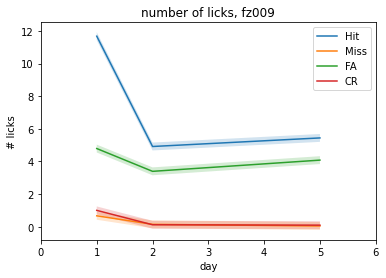

In [17]:
# per outcome
day = 1
print('start')
for outcome_index in range(1,5):
    iday = 0
    days = []
    nalllicks = []
    bandwidth = []
    # f, axs = plt.subplots(2, n_valid_days, gridspec_kw={'width_ratios': np.ones(n_valid_days)}, figsize=(5*n_valid_days, 5))
    for day in range(1, nDays+1):
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            iday += 1
            daily_cues = []
            daily_outcomes = []
            daily_responses = []
            daily_firstlicks = []
            daily_alllicks = []
            for i in iblocks:
                block = data[0, i]
                # normalize doesn't have much effect on the result, so set it to False
                cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, normalize=False)
                daily_cues.append(cues)
                daily_outcomes.append(outcomes)
                daily_responses.append(stim_resp)
                daily_firstlicks.append(firstlicks)
                daily_alllicks.append(alllicks)

            daily_cues = np.hstack(daily_cues)
            daily_outcomes = np.hstack(daily_outcomes)
            daily_responses = np.vstack(daily_responses)
            daily_firstlicks = np.hstack(daily_firstlicks)
            daily_alllicks = np.vstack(daily_alllicks)

            NN = daily_responses.shape[1]

            # from scipy.stats import pearsonr
            daily_spks = daily_responses.transpose(1, 0, 2)
            daily_spks = daily_spks.reshape(NN, -1)
            avg_resp = np.mean(daily_spks, axis=0) # ntrials x 75

            # hit responses
            ioutcome = np.where(daily_outcomes == outcome_index)[0]
            resp = daily_responses[ioutcome]
            lick = daily_alllicks[ioutcome]
            cue = daily_cues[i]
            NT = resp.shape[-1]
            resp = resp.reshape(-1, NT)
            resp = np.mean(resp, axis=0)
            # plt.subplot(2, n_valid_days, iday)
            x = np.arange(NT)
            nlicks = np.mean(np.sum(lick[:, 30:], axis=1))
            atd = np.std(np.sum(lick[:, 30:], axis=1))
            days.append(day)
            nalllicks.append(nlicks)
            bandwidth.append(std)
    bandwidth = np.array(bandwidth)
    plt.plot(days, nalllicks, label=outcome_list[outcome_index-1])
    plt.fill_between(days, nalllicks+bandwidth/2, nalllicks-bandwidth/2, alpha=.2)
plt.legend()
plt.xlabel('day')
plt.ylabel('# licks')
plt.title('number of licks, {}'.format(mouse_name))
plt.xlim([0, nDays+1])
plt.show()

# decrease activity

start


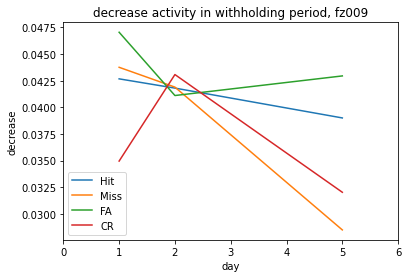

In [21]:
day = 1
print('start')
for outcome_index in range(1,5):
    iday = 0
    inhis = []
    days = []
    # f, axs = plt.subplots(2, n_valid_days, gridspec_kw={'width_ratios': np.ones(n_valid_days)}, figsize=(5*n_valid_days, 5))
    for day in range(1, nDays+1):
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            iday += 1
            daily_cues = []
            daily_outcomes = []
            daily_responses = []
            daily_firstlicks = []
            daily_alllicks = []
            for i in iblocks:
                block = data[0, i]
                # normalize doesn't have much effect on the result, so set it to False
                cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, normalize=False)
                daily_cues.append(cues)
                daily_outcomes.append(outcomes)
                daily_responses.append(stim_resp)
                daily_firstlicks.append(firstlicks)
                daily_alllicks.append(alllicks)

            daily_cues = np.hstack(daily_cues)
            daily_outcomes = np.hstack(daily_outcomes)
            daily_responses = np.vstack(daily_responses)
            daily_firstlicks = np.hstack(daily_firstlicks)
            daily_alllicks = np.vstack(daily_alllicks)

            NN = daily_responses.shape[1]

            # hit responses
            ioutcome = np.where(daily_outcomes == outcome_index)[0]
            resp = daily_responses[ioutcome]
            NT = resp.shape[-1]
            resp = resp.reshape(-1, NT)
            resp = np.mean(resp, axis=0)
            min_idx = max(np.argmin(resp[10:30])+10, 11)
            inhi = resp[10:min_idx].max() - resp[10:30].min()
            days.append(day)
            inhis.append(inhi)
    plt.plot(days, inhis, label=outcome_list[outcome_index-1])
plt.legend()
plt.xlabel('day')
plt.ylabel('decrease')
plt.title('decrease activity in withholding period, {}'.format(mouse_name))
plt.xlim([0, nDays+1])
plt.show()

# max response

start


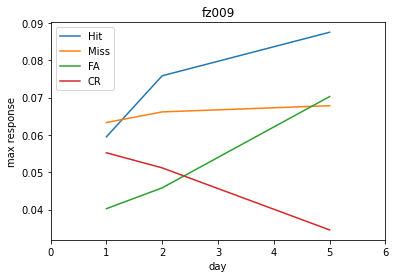

In [22]:
day = 1
print('start')
for outcome_index in range(1,5):
    iday = 0
    inhis = []
    days = []
    # f, axs = plt.subplots(2, n_valid_days, gridspec_kw={'width_ratios': np.ones(n_valid_days)}, figsize=(5*n_valid_days, 5))
    for day in range(1, nDays+1):
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            iday += 1
            daily_cues = []
            daily_outcomes = []
            daily_responses = []
            daily_firstlicks = []
            daily_alllicks = []
            for i in iblocks:
                block = data[0, i]
                # normalize doesn't have much effect on the result, so set it to False
                cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, normalize=False)
                daily_cues.append(cues)
                daily_outcomes.append(outcomes)
                daily_responses.append(stim_resp)
                daily_firstlicks.append(firstlicks)
                daily_alllicks.append(alllicks)

            daily_cues = np.hstack(daily_cues)
            daily_outcomes = np.hstack(daily_outcomes)
            daily_responses = np.vstack(daily_responses)
            daily_firstlicks = np.hstack(daily_firstlicks)
            daily_alllicks = np.vstack(daily_alllicks)

            NN = daily_responses.shape[1]

            # hit responses
            ioutcome = np.where(daily_outcomes == outcome_index)[0]
            resp = daily_responses[ioutcome]
            NT = resp.shape[-1]
            resp = resp.reshape(-1, NT)
            resp = np.mean(resp, axis=0)
            inhi = np.max(resp)
            days.append(day)
            inhis.append(inhi)
    plt.plot(days, inhis, label=outcome_list[outcome_index-1])
plt.legend()
plt.xlabel('day')
plt.ylabel('max response')
plt.title('{}'.format(mouse_name))
plt.xlim([0, nDays+1])
plt.show()

# fz017 axon cluster

In [325]:
import random
random.seed(0)
np.random.seed(0)
day = 26
iblocks = daily_blocks(data, day)
daily_spks = []
daily_behav = []
for i in iblocks:
    block = data[0, i]
    behavior = block['behavdata']
    raw_spks = block['imagingdata']
    NN, NT = raw_spks.shape
    print(raw_spks.shape)
    daily_spks.append(raw_spks)
    daily_behav.append(behavior)
    
daily_spks = np.hstack(daily_spks)
print('day {} spk shape: {}'.format(day, daily_spks.shape))

daily_behav = np.hstack(daily_behav)
print('day {} behavior shape: {}'.format(day, daily_behav.shape))

from scipy.stats import zscore
norm_spks = zscore(daily_spks, axis=1)

(186, 12991)
(186, 11905)
day 26 spk shape: (186, 24896)
day 26 behavior shape: (4, 24896)


In [326]:
from rastermap.mapping import Rastermap
model = Rastermap(n_X=20)
model.fit(norm_spks)

nmin 186
0.015002965927124023
0.6587910652160645
0.8518362045288086
0.8548367023468018
(360, 400)
(50,)
1.0
time; iteration;  explained PC variance
0.01s     0        0.0452      8
0.32s    10        0.1307      24
0.58s    20        0.3162      80
0.82s    30        0.7471      360
1.02s    40        0.7471      360
1.16s   final      0.7471
5.84s upsampled    0.7471


In [327]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(model.embedding)

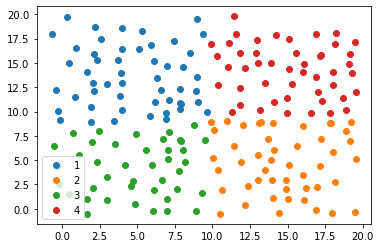

In [328]:
X = model.embedding
for i in range(4):
    idx = np.where(kmeans.labels_ == i)[0]
    plt.scatter(X[idx, 0], X[idx, 1], label='%d'%(i+1))
plt.legend()
plt.show()

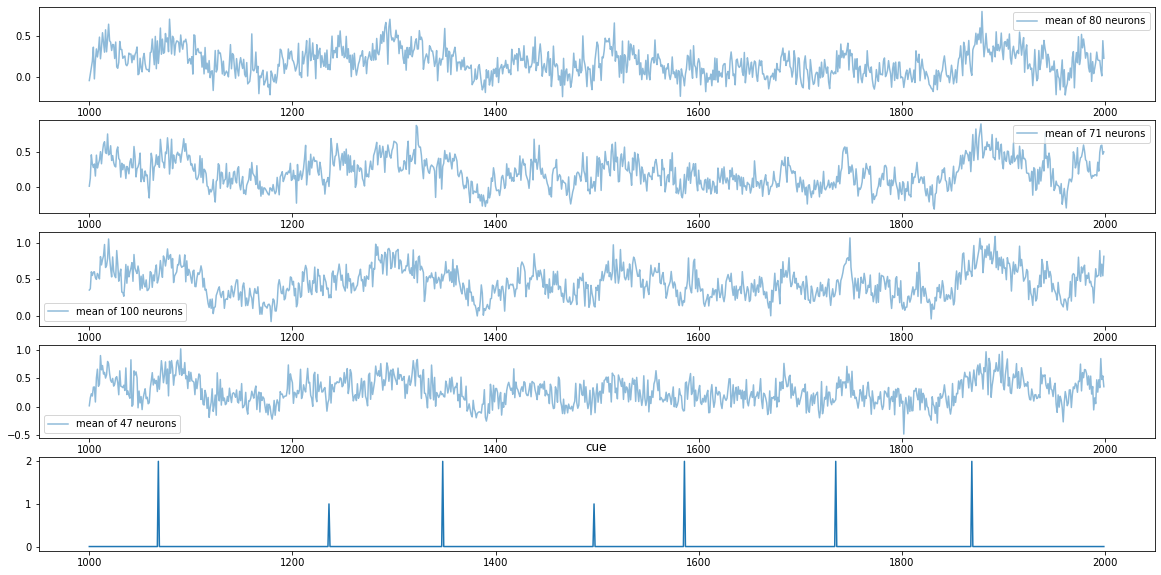

In [322]:
plt.figure(figsize=(20, 10))
K = 4
for i in range(K):
    plt.subplot(K+1, 1, i+1)
    idx = np.where(kmeans.labels_ == i)[0]
    plt.plot(np.arange(1000, 2000), np.mean(norm_spks[idx, 1000:2000], axis=0), label='mean of {} neurons'.format(len(idx)), alpha=0.5)
    plt.legend()


plt.subplot(K+1, 1, K+1)
plt.plot(np.arange(1000, 2000), daily_behav[0, 1000:2000])
plt.title('cue')
plt.show()

In [329]:
# stim evoke response of cluster 1 VS 2
# c_id = 4 # cluster id
iblocks = daily_blocks(data, day)
daily_cues = []
daily_outcomes = []
daily_responses = []
daily_firstlicks = []
daily_alllicks = []
for i in iblocks:
    block = data[0, i]
    # normalize doesn't have much effect on the result, so set it to False
    cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, normalize=False)
    daily_cues.append(cues)
    daily_outcomes.append(outcomes)
    daily_responses.append(stim_resp)
    daily_firstlicks.append(firstlicks)
    daily_alllicks.append(alllicks)

daily_cues = np.hstack(daily_cues)
daily_outcomes = np.hstack(daily_outcomes)
daily_responses = np.vstack(daily_responses)
daily_firstlicks = np.hstack(daily_firstlicks)
daily_alllicks = np.vstack(daily_alllicks)

print('day {} spk shape: {}'.format(day, daily_responses.shape))
print('day {} behavior shape: {}'.format(day, daily_outcomes.shape))
print('day {} alllick shape: {}'.format(day, daily_alllicks.shape))

day 26 spk shape: (200, 186, 75)
day 26 behavior shape: (200,)
day 26 alllick shape: (200, 75)


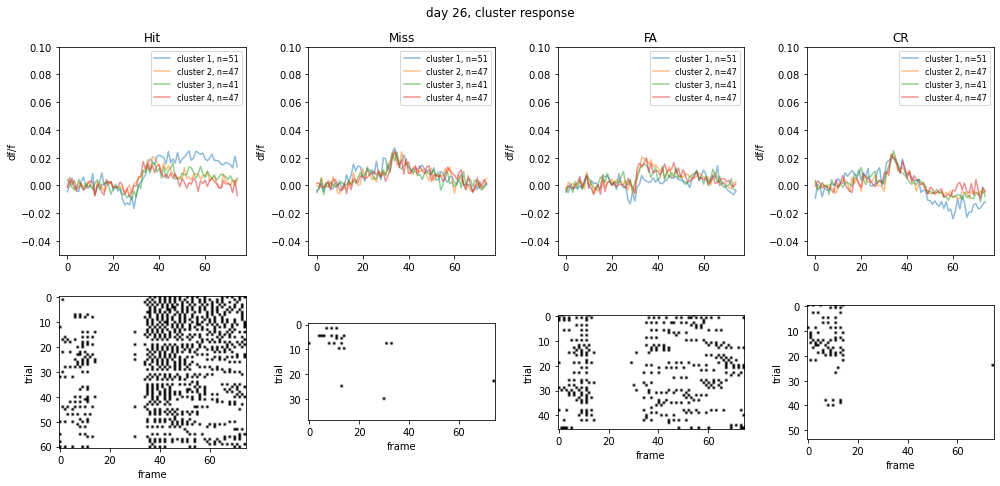

In [330]:
fig = plt.figure(figsize=(14, 7))
fig.patch.set_facecolor('white')
for outcome_index in range(1,5):
    # hit responses
    ioutcome = np.where(daily_outcomes == outcome_index)[0]
    lick = daily_alllicks[ioutcome]
    
    plt.subplot(2,4,outcome_index)
    
    for c_id in range(1, 5): # iterate through clusters
        idx = np.where(kmeans.labels_ == (c_id-1))[0]
        cluster_spks = daily_responses[:, idx, :]
        resp = cluster_spks[ioutcome]
        NT = resp.shape[-1]
        resp = resp.reshape(-1, NT)
        resp = np.mean(resp, axis=0)
        x = np.arange(NT)
        plt.plot(x, resp, label='cluster {}, n={}'.format(c_id, len(idx)), alpha=0.5)
    plt.title(outcome_list[outcome_index-1])
    plt.ylabel('df/f')
    plt.ylim([-0.05, 0.1])
    plt.legend(fontsize=8)
    plt.subplot(2,4,4+outcome_index)
    plt.imshow(lick, cmap='binary')
    plt.xlabel('frame')
    plt.ylabel('trial')
plt.suptitle('day {}, cluster response'.format(day, c_id))
plt.tight_layout()
plt.show()

# daily blockwise response

In [15]:
titles = ['Hit', 'Miss', 'Correct Rejection', 'False Alarm']
cmap = plt.cm.get_cmap('viridis_r')
for day in range(1, nDays+1):
    fig_save_path = os.path.join('figures', 'day-{}_avg-response'.format(day)) # , 'daily_avg_response'
    plt.figure(figsize=(12, 7))
    iblocks = daily_blocks(data, day)
    nb = -1
    if len(iblocks)>0:
        for i in iblocks:
            nb += 1
            block = data[0, i]
            pb_spks = get_tone_response_df(block, context='pb')
            rl_spks = get_tone_response_df(block, context='rl')
            for k in range(4):
                plt.subplot(2, 2, k+1)
                plt.title(titles[k])
                if len(rl_spks[k])>0:
                    plt.plot(np.average(rl_spks[k], axis=0), label='block {}, rl'.format(nb+1), color=cmap(0.3*nb+0.05))
                if len(pb_spks[k])>0:
                    plt.plot(np.average(pb_spks[k], axis=0), label='block {}, pb'.format(nb+1), color=cmap(0.3*nb+0.05), linestyle=':')
                plt.axvline(x=30, c='red')
                # plt.axhline(y=0, c='grey', alpha=0.2)
                plt.ylim([-0.08, 0.2])
                plt.legend()
    plt.suptitle('day {} average response'.format(day))
    plt.savefig(fig_save_path)
    plt.close()

## early mid and late

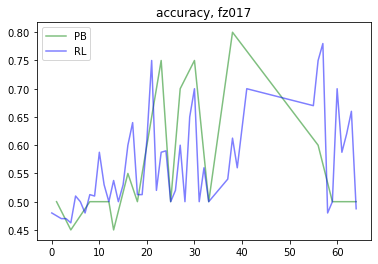

In [221]:
colors = np.array(["green", "blue"])
nBlocks = data.shape[-1]
pbRes = np.zeros((4, nBlocks))
rlRes = np.zeros((4, nBlocks))
nPB = np.zeros(nBlocks)
for i in range(nBlocks):
    block = data[0, i]
    behavior = block['behavdata']
    if behavior.shape[-1] > 0:
        nPB[i] = np.sum(behavior[0]>2)
        outcome = behavior[1]
        if nPB[i] > 0:
            pbIdx = np.where(behavior[0]>2)
            pbOutcome = outcome[pbIdx]
            for j in range(4):
                pbRes[j, i] = np.sum(pbOutcome == j+1) / nPB[i]
        
        rlIdx = np.where(behavior[0]<3)
        rlOutcome = outcome[rlIdx]
        for j in range(4):
            rlRes[j, i] = np.sum(rlOutcome == j+1) / (100 - nPB[i])
x = np.arange(nBlocks)
ptrue = pbRes[0] + pbRes[3]
rtrue = rlRes[0] + rlRes[3]

p_nonzero = np.where(ptrue>0)
r_nonzero = np.where(rtrue>0)
plt.plot(x[p_nonzero], ptrue[p_nonzero], color=colors[0], alpha=0.5, label='PB')
plt.plot(x[r_nonzero], rtrue[r_nonzero], color=colors[1], alpha=0.5, label='RL')
plt.title('accuracy, {}'.format(mouse_name))
plt.legend()

In [222]:
for i in range(len(ptrue)):
    if ptrue[i] > 0:
        print('[block {}] accuracy of rl: {:.3f}, pb trials: {:.3f}'.format(i, rtrue[i], ptrue[i]))

[block 1] accuracy of rl: 0.475, pb trials: 0.500
[block 4] accuracy of rl: 0.463, pb trials: 0.450
[block 8] accuracy of rl: 0.512, pb trials: 0.500
[block 10] accuracy of rl: 0.588, pb trials: 0.500
[block 12] accuracy of rl: 0.500, pb trials: 0.500
[block 13] accuracy of rl: 0.537, pb trials: 0.450
[block 16] accuracy of rl: 0.600, pb trials: 0.550
[block 18] accuracy of rl: 0.512, pb trials: 0.500
[block 19] accuracy of rl: 0.512, pb trials: 0.550
[block 23] accuracy of rl: 0.588, pb trials: 0.750
[block 25] accuracy of rl: 0.500, pb trials: 0.500
[block 27] accuracy of rl: 0.600, pb trials: 0.700
[block 30] accuracy of rl: 0.700, pb trials: 0.750
[block 33] accuracy of rl: 0.500, pb trials: 0.500
[block 38] accuracy of rl: 0.613, pb trials: 0.800
[block 56] accuracy of rl: 0.750, pb trials: 0.600
[block 59] accuracy of rl: 0.500, pb trials: 0.500
[block 61] accuracy of rl: 0.588, pb trials: 0.500
[block 64] accuracy of rl: 0.488, pb trials: 0.500


e:\kishorelab\env\fengtong\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
e:\kishorelab\env\fengtong\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
e:\kishorelab\env\fengtong\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
e:\kishorelab\env\fengtong\lib\site-packages\numpy\lib\function_base.py:380: RuntimeW

Text(0.5, 0.98, 'average response')

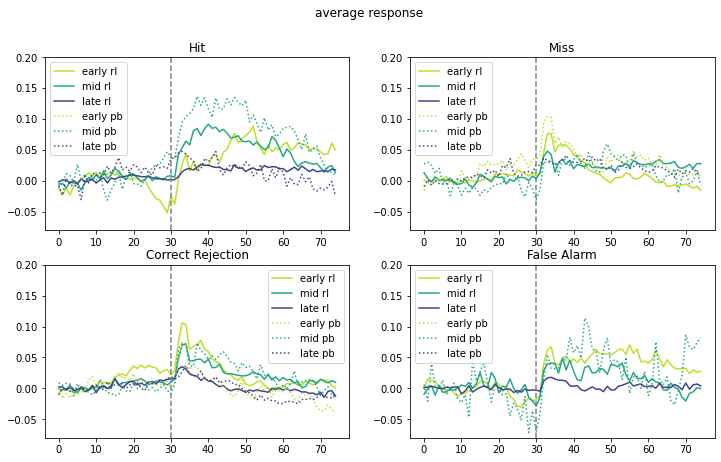

In [233]:
# load spks, block 1, 18, 39 for mouse 0
## [block 1] accuracy of rl: 0.550, pb trials: 0.450
## [block 18] accuracy of rl: 0.637, pb trials: 0.850
## [block 39] accuracy of rl: 0.738, pb trials: 0.850
# load spks, block 1, 23, 56 for mouse 0
## [block 1] accuracy of rl: 0.475, pb trials: 0.500
## [block 23] accuracy of rl: 0.588, pb trials: 0.750
## [block 56] accuracy of rl: 0.750, pb trials: 0.600
early_num = 1
mid_num = 23
late_num = 56
early_block = data[0, early_num]
mid_block = data[0, mid_num]
late_block = data[0, late_num]
blocks = [early_block, mid_block, late_block]

early_spks_list = get_tone_response_df(early_block, context='rl')
mid_spks_list = get_tone_response_df(mid_block, context='rl')
late_spks_list = get_tone_response_df(late_block, context='rl')

pb_early_spks_list = get_tone_response_df(early_block, context='pb')
pb_mid_spks_list = get_tone_response_df(mid_block, context='pb')
pb_late_spks_list = get_tone_response_df(late_block, context='pb')

btitles = ['Hit', 'Miss', 'Correct Rejection', 'False Alarm']
x = np.arange(early_spks_list[0].shape[-1])
fig = plt.figure(figsize=(12, 7))
fig.patch.set_facecolor('white')
cmap = plt.cm.get_cmap('viridis_r')
# colors = cmap(np.linspace(0,1,n))
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.title(btitles[k])
    plt.plot(np.average(early_spks_list[k], axis=0), label='early rl', color=cmap(0.1))
    plt.plot(np.average(mid_spks_list[k], axis=0), label='mid rl', color=cmap(0.4))
    plt.plot(np.average(late_spks_list[k], axis=0), label='late rl', color=cmap(0.8))
    plt.plot(np.average(pb_early_spks_list[k], axis=0), label='early pb', color=cmap(0.1), linestyle=':')
    plt.plot(np.average(pb_mid_spks_list[k], axis=0), label='mid pb', color=cmap(0.4), linestyle=':')
    plt.plot(np.average(pb_late_spks_list[k], axis=0), label='late pb', color=cmap(0.8), linestyle=':')
    plt.axvline(x=30, c='grey', linestyle='--')
    # plt.axhline(y=0, c='grey', alpha=0.2)
    plt.ylim([-0.08, 0.2])
    plt.legend()
plt.suptitle('average response')

# outcome distribution

## outcomes around outcome (per day)

In [29]:
day = 1
for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    plt.figure(figsize=(20, 10))
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for i in iblocks:
            block = data[0, i]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, normalize=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_firstlicks = np.hstack(daily_firstlicks)
        daily_alllicks = np.vstack(daily_alllicks)

        print('day {} spk shape: {}'.format(day, daily_responses.shape))
        print('day {} behavior shape: {}'.format(day, daily_outcomes.shape))
        print('day {} alllick shape: {}'.format(day, daily_alllicks.shape))

        NN = daily_responses.shape[1]
        NT = daily_responses.shape[0]

        for outcome_index in range(1,5):
            # hit responses
            ioutcome = np.where(daily_outcomes == outcome_index)[0]
            ibefore = ioutcome-1
            iafter = ioutcome+1
            # remove not valid indexes
            idx = np.where((0<=ibefore)&(ibefore<NT))[0]
            ibefore = ibefore[idx]
            idx = np.where((0<=iafter)&(iafter<NT))[0]
            iafter = iafter[idx]
            plt.subplot(2,4,outcome_index)
            plt.title('before {}'.format(outcome_list[outcome_index-1]))
            nbefore = []
            ibefore = daily_outcomes[ibefore]
            iafter = daily_outcomes[iafter]
            for k in range(1,5):
                idx = np.where(ibefore==k)[0]
                nbefore.append(len(idx))
            plt.bar(outcome_list, nbefore)
            plt.ylabel('N')
            plt.subplot(2,4,4+outcome_index)
            plt.title('after {}'.format(outcome_list[outcome_index-1]))
            nafter = []
            for k in range(1,5):
                idx = np.where(iafter==k)[0]
                nafter.append(len(idx))
            plt.bar(outcome_list, nafter)
            plt.ylabel('N')
        plt.suptitle('day {}'.format(day))
        fig_save_path = os.path.join('figures',  'outcome_distribution_{}_day-{}'.format(mouse_name, day))
        plt.savefig(fig_save_path, dpi=100)
        plt.close()

day 1 spk shape: (300, 175, 75)
day 1 behavior shape: (300,)
day 1 alllick shape: (300, 75)
day 2 spk shape: (300, 141, 75)
day 2 behavior shape: (300,)
day 2 alllick shape: (300, 75)
day 3 spk shape: (300, 205, 75)
day 3 behavior shape: (300,)
day 3 alllick shape: (300, 75)
day 4 spk shape: (200, 139, 75)
day 4 behavior shape: (200,)
day 4 alllick shape: (200, 75)
day 5 spk shape: (200, 158, 75)
day 5 behavior shape: (200,)
day 5 alllick shape: (200, 75)
day 6 spk shape: (300, 169, 75)
day 6 behavior shape: (300,)
day 6 alllick shape: (300, 75)
day 7 spk shape: (200, 171, 75)
day 7 behavior shape: (200,)
day 7 alllick shape: (200, 75)
day 8 spk shape: (200, 187, 75)
day 8 behavior shape: (200,)
day 8 alllick shape: (200, 75)
day 9 spk shape: (300, 198, 75)
day 9 behavior shape: (300,)
day 9 alllick shape: (300, 75)
day 15 spk shape: (300, 180, 75)
day 15 behavior shape: (300,)
day 15 alllick shape: (300, 75)


<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

## all days

In [340]:
valid_days = []
for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        valid_days.append(day)
valid_days = np.array(valid_days)

In [341]:
befores = np.zeros((4, 4, len(valid_days)))
afters = np.zeros((4, 4, len(valid_days)))
for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        iday = np.where(valid_days == day)[0][0]
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for i in iblocks:
            block = data[0, i]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, normalize=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_firstlicks = np.hstack(daily_firstlicks)
        daily_alllicks = np.vstack(daily_alllicks)

        print('day {} spk shape: {}'.format(day, daily_responses.shape))
        print('day {} behavior shape: {}'.format(day, daily_outcomes.shape))
        print('day {} alllick shape: {}'.format(day, daily_alllicks.shape))
        
        NN = daily_responses.shape[1]
        NT = daily_responses.shape[0]

        for outcome_index in range(1,5):
            # hit responses
            ioutcome = np.where(daily_outcomes == outcome_index)[0]
            if len(ioutcome) > 0:
                ibefore = ioutcome-1
                iafter = ioutcome+1
                # remove not valid indexes
                idx = np.where((0<=ibefore)&(ibefore<NT))[0]
                ibefore = ibefore[idx]
                idx = np.where((0<=iafter)&(iafter<NT))[0]
                iafter = iafter[idx]
                ibefore = daily_outcomes[ibefore]
                iafter = daily_outcomes[iafter]
                for k in range(1,5):
                    idx = np.where(ibefore==k)[0]
                    befores[outcome_index-1, k-1, iday] = len(idx) / len(ioutcome)
                    idx = np.where(iafter==k)[0]
                    afters[outcome_index-1, k-1, iday] = len(idx) / len(ioutcome)

day 1 spk shape: (300, 175, 75)
day 1 behavior shape: (300,)
day 1 alllick shape: (300, 75)
day 2 spk shape: (300, 141, 75)
day 2 behavior shape: (300,)
day 2 alllick shape: (300, 75)
day 3 spk shape: (300, 205, 75)
day 3 behavior shape: (300,)
day 3 alllick shape: (300, 75)
day 4 spk shape: (200, 139, 75)
day 4 behavior shape: (200,)
day 4 alllick shape: (200, 75)
day 5 spk shape: (200, 158, 75)
day 5 behavior shape: (200,)
day 5 alllick shape: (200, 75)
day 6 spk shape: (300, 169, 75)
day 6 behavior shape: (300,)
day 6 alllick shape: (300, 75)
day 7 spk shape: (200, 171, 75)
day 7 behavior shape: (200,)
day 7 alllick shape: (200, 75)
day 8 spk shape: (200, 187, 75)
day 8 behavior shape: (200,)
day 8 alllick shape: (200, 75)
day 9 spk shape: (300, 198, 75)
day 9 behavior shape: (300,)
day 9 alllick shape: (300, 75)
day 15 spk shape: (300, 180, 75)
day 15 behavior shape: (300,)
day 15 alllick shape: (300, 75)


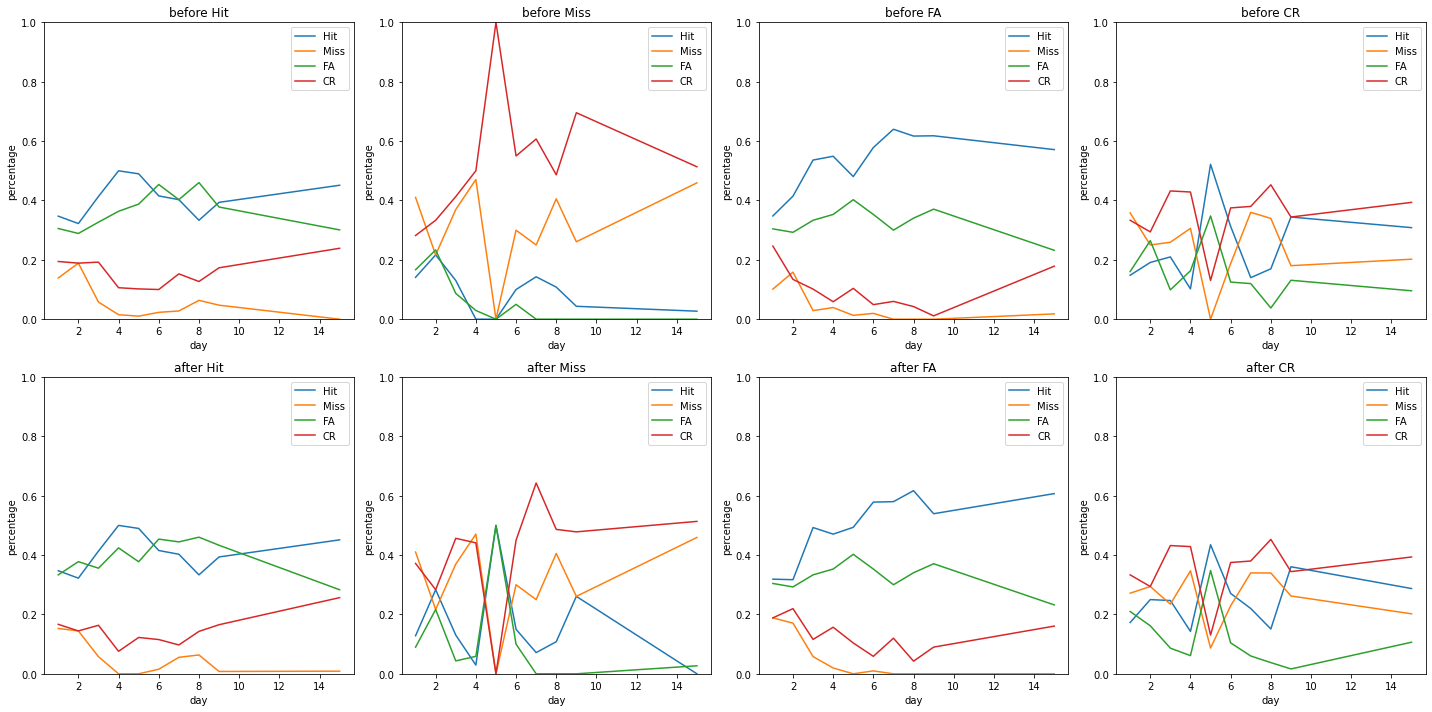

In [342]:
fig = plt.figure(figsize=(20, 10))
fig.patch.set_facecolor('white')
for outcome_index in range(1,5):
    # hit responses
    ioutcome = np.where(daily_outcomes == outcome_index)[0]
    ibefore = ioutcome-1
    iafter = ioutcome+1
    # remove not valid indexes
    idx = np.where((0<=ibefore)&(ibefore<NT))[0]
    ibefore = ibefore[idx]
    idx = np.where((0<=iafter)&(iafter<NT))[0]
    iafter = iafter[idx]
    plt.subplot(2,4,outcome_index)
    plt.title('before {}'.format(outcome_list[outcome_index-1]))
    for i in range(4):
        plt.plot(valid_days, befores[outcome_index-1, i], label=outcome_list[i])
    plt.legend()
    plt.ylabel('percentage')
    plt.xlabel('day')
    plt.ylim([0,1])
    plt.subplot(2,4,4+outcome_index)
    plt.title('after {}'.format(outcome_list[outcome_index-1]))
    for i in range(4):
        plt.plot(valid_days, afters[outcome_index-1, i], label=outcome_list[i])
    plt.legend()
    plt.ylabel('percentage')
    plt.xlabel('day')
    plt.ylim([0,1])
# plt.suptitle('day {}'.format(day))
# fig_save_path = os.path.join('figures',  'outcome_distribution_{}_day-{}'.format(mouse_name, day))
# plt.savefig(fig_save_path, dpi=100)
# plt.close()
plt.tight_layout()
plt.show()

# tonic and phasic signals

## visualize filter

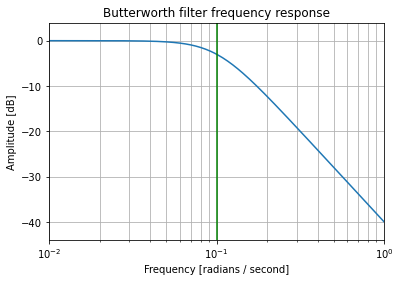

In [103]:
from scipy import signal
import matplotlib.pyplot as plt
b, a = signal.butter(2, 0.1, 'low', analog=True)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(0.1, color='green') # cutoff frequency
plt.show()

## get daily spks

In [343]:
day = 1
iblocks = daily_blocks(data, day)
daily_spks = []
daily_behav = []
for i in iblocks:
    block = data[0, i]
    behavior = block['behavdata']
    raw_spks = block['imagingdata']
    NN, NT = raw_spks.shape
    print(raw_spks.shape)
    daily_spks.append(raw_spks)
    daily_behav.append(behavior)
    
daily_spks = np.hstack(daily_spks)
print('day {} spk shape: {}'.format(day, daily_spks.shape))

daily_behav = np.hstack(daily_behav)
print('day {} behavior shape: {}'.format(day, daily_behav.shape))

from scipy.stats import zscore
norm_spks = zscore(daily_spks, axis=1)

(175, 13540)
(175, 11474)
(175, 9940)
day 1 spk shape: (175, 34954)
day 1 behavior shape: (4, 34954)


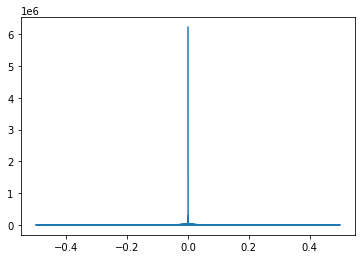

In [105]:
import numpy.fft as fft
avg_spks=np.mean(daily_spks, axis=0)
spectrum = fft.fft(avg_spks)
freq = fft.fftfreq(len(spectrum))
plt.plot(freq, abs(spectrum))

(0.0, 10000.0)

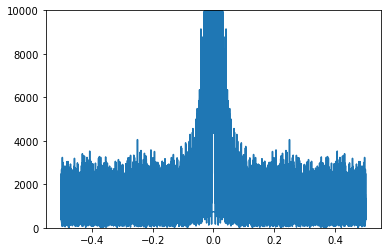

In [101]:
plt.plot(freq, abs(spectrum))
plt.ylim([0, 10000])

(-0.1, 0.1)

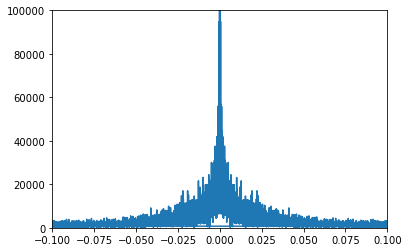

In [139]:
plt.plot(freq, abs(spectrum))
plt.ylim([0, 100000])
plt.xlim([-0.1,0.1])

## filtering

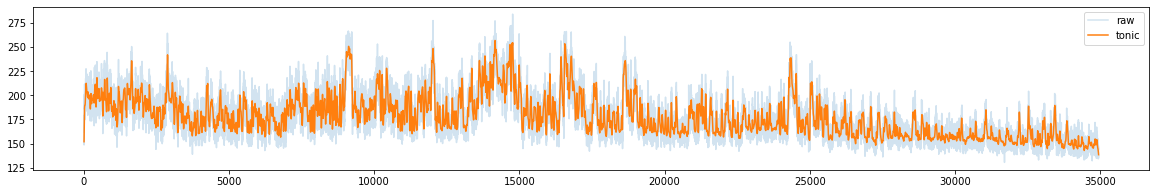

In [344]:
b, a = signal.butter(2, 0.05, 'low', analog=False)
w, h = signal.freqs(b, a)
avg_spks=np.mean(daily_spks, axis=0)
y = signal.filtfilt(b, a, avg_spks)
plt.figure(figsize=(20, 3))
x = np.arange(len(avg_spks))
plt.plot(x, avg_spks, label='raw', alpha=0.2)
plt.plot(x, y, label='tonic')
plt.legend()
plt.show()

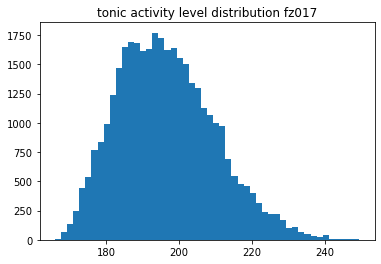

In [190]:
plt.hist(y, bins=50)
plt.title('tonic activity level distribution ' + mouse_name)
plt.show()

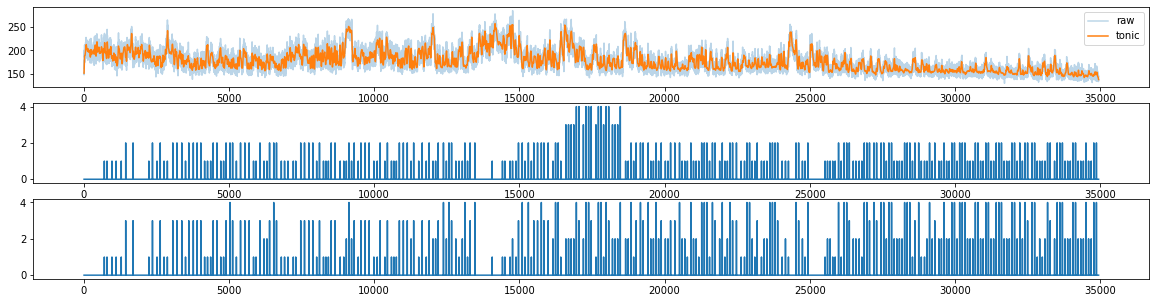

In [156]:
trange = np.arange(0, len(avg_spks))
plt.figure(figsize=(20, 5))
plt.subplot(311)
plt.plot(x[trange], avg_spks[trange], label='raw', alpha=0.3)
plt.plot(x[trange], y[trange], label='tonic')
plt.legend()
plt.subplot(312)
plt.plot(x[trange], daily_behav[0, trange])
plt.subplot(313)
plt.plot(x[trange], daily_behav[1, trange])
plt.show()

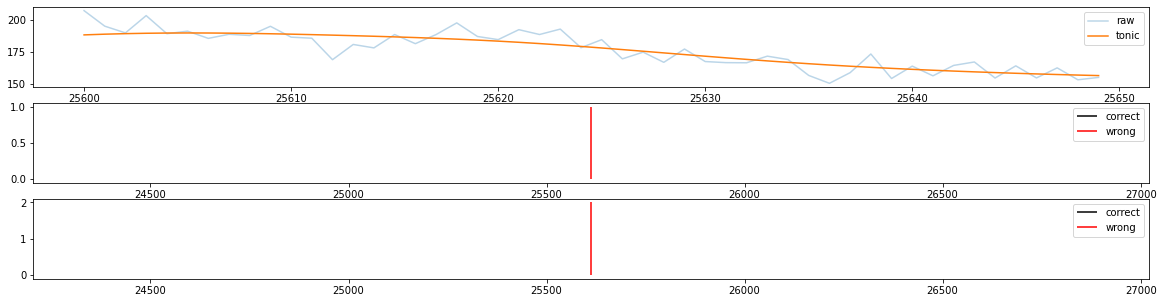

In [162]:
trange = np.arange(0, len(avg_spks))
trange = np.arange(25600, 25650)
plt.figure(figsize=(20, 5))
plt.subplot(311)
plt.plot(x[trange], avg_spks[trange], label='raw', alpha=0.3)
plt.plot(x[trange], y[trange], label='tonic')
plt.legend()
behav = daily_behav[:, trange]
icorrect = np.where((behav[1]==1)|(behav[1]==4))[0]
iwrong = np.where((behav[1]==2)|(behav[1]==3))[0]
plt.subplot(312)
plt.vlines(x[trange[icorrect]], ymin=0, ymax=behav[0, icorrect], label='correct', color='black')
plt.vlines(x[trange[iwrong]], ymin=0, ymax=behav[0, iwrong], label='wrong', color='red')
plt.legend()
plt.subplot(313)
plt.vlines(x[trange[icorrect]], ymin=0, ymax=behav[1, icorrect], label='correct', color='black')
plt.vlines(x[trange[iwrong]], ymin=0, ymax=behav[1, iwrong], label='wrong', color='red')
plt.legend()
plt.show()

## tonic activity VS outcome (all)

In [ ]:
day = 1
for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        plt.figure(figsize=(5,3))
        daily_spks = []
        daily_behav = []
        for i in iblocks:
            block = data[0, i]
            behavior = block['behavdata']
            raw_spks = block['imagingdata']
            NN, NT = raw_spks.shape
            print(raw_spks.shape)
            daily_spks.append(raw_spks)
            daily_behav.append(behavior)

        daily_spks = np.hstack(daily_spks)
        print('day {} spk shape: {}'.format(day, daily_spks.shape))

        daily_behav = np.hstack(daily_behav)
        print('day {} behavior shape: {}'.format(day, daily_behav.shape))
        daily_outcomes = daily_behav[1]
        daily_cues = daily_behav[0]

#         from scipy.stats import zscore
#         norm_spks = zscore(daily_spks, axis=1)
    
        # get the average tonic activity level before each outcome
        b, a = signal.butter(2, 0.05, 'low', analog=False)
        w, h = signal.freqs(b, a)
        avg_spks = np.mean(daily_spks, axis=0)
        tonic_spks = signal.filtfilt(b, a, avg_spks)

        for outcome_index in range(1,5):
            # plot distribution
            # hit responses
            ioutcome = np.where(daily_outcomes == outcome_index)[0]
            avg_tonic_level = np.zeros(len(ioutcome))
            for i, ind in enumerate(ioutcome):
                avg_tonic_level[i] = np.mean(tonic_spks[ind-45:ind])
            plt.hist(avg_tonic_level, bins=10, alpha=0.3, label=outcome_list[outcome_index-1], density=True)
        plt.legend()
        plt.xlabel('average tonic activity level')
        plt.ylabel('count')
        plt.title('day {}, tonic activity level before cue'.format(day))
        plt.tight_layout()
        fig_save_path = os.path.join('figures',  'tonic-level_{}_day-{}'.format(mouse_name, day))
        plt.savefig(fig_save_path, dpi=100)
        plt.close()

## tonic activity VS outcome (in one figure)

In [358]:
day = 1
tonic_levels= [[], [], [], []]
days = []
for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_spks = []
        daily_behav = []
        for i in iblocks:
            block = data[0, i]
            behavior = block['behavdata']
            raw_spks = block['imagingdata']
            NN, NT = raw_spks.shape
            daily_spks.append(raw_spks)
            daily_behav.append(behavior)

        daily_spks = np.hstack(daily_spks)
        print('day {} spk shape: {}'.format(day, daily_spks.shape))

        daily_behav = np.hstack(daily_behav)
        print('day {} behavior shape: {}'.format(day, daily_behav.shape))
        daily_outcomes = daily_behav[1]
        daily_cues = daily_behav[0]

#         from scipy.stats import zscore
#         norm_spks = zscore(daily_spks, axis=1)
    
        # get the average tonic activity level before each outcome
        b, a = signal.butter(2, 0.05, 'low', analog=False)
        w, h = signal.freqs(b, a)
        avg_spks = np.mean(daily_spks, axis=0)
        tonic_spks = signal.filtfilt(b, a, avg_spks)

        for outcome_index in range(1,5):
            # plot distribution
            # hit responses
            ioutcome = np.where(daily_outcomes == outcome_index)[0]
            avg_tonic_level = np.zeros(len(ioutcome))
            for i, ind in enumerate(ioutcome):
                avg_tonic_level[i] = np.mean(tonic_spks[ind-45:ind])
            tonic_levels[outcome_index-1].append(np.mean(avg_tonic_level))
        days.append(day)

day 1 spk shape: (447, 35811)
day 1 behavior shape: (4, 35811)
day 2 spk shape: (386, 33882)
day 2 behavior shape: (4, 33882)
day 3 spk shape: (514, 9535)
day 3 behavior shape: (4, 9535)
day 4 spk shape: (313, 21238)
day 4 behavior shape: (4, 21238)
day 5 spk shape: (121, 26233)
day 5 behavior shape: (4, 26233)
day 6 spk shape: (212, 22619)


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


day 6 behavior shape: (4, 22619)
day 7 spk shape: (321, 21463)
day 7 behavior shape: (4, 21463)
day 8 spk shape: (271, 26253)
day 8 behavior shape: (4, 26253)
day 9 spk shape: (245, 22566)
day 9 behavior shape: (4, 22566)
day 10 spk shape: (405, 39423)
day 10 behavior shape: (4, 39423)
day 11 spk shape: (348, 22921)
day 11 behavior shape: (4, 22921)
day 12 spk shape: (176, 20332)
day 12 behavior shape: (4, 20332)
day 13 spk shape: (76, 33683)
day 13 behavior shape: (4, 33683)
day 14 spk shape: (217, 32207)
day 14 behavior shape: (4, 32207)
day 15 spk shape: (374, 22571)
day 15 behavior shape: (4, 22571)
day 17 spk shape: (298, 47326)
day 17 behavior shape: (4, 47326)
day 23 spk shape: (324, 34477)
day 23 behavior shape: (4, 34477)
day 24 spk shape: (250, 21621)
day 24 behavior shape: (4, 21621)
day 25 spk shape: (236, 33238)
day 25 behavior shape: (4, 33238)
day 26 spk shape: (186, 24896)
day 26 behavior shape: (4, 24896)


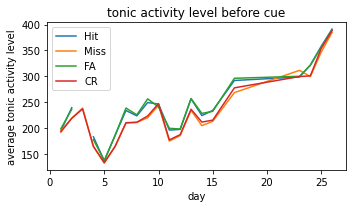

In [359]:
plt.figure(figsize=(5,3))
for i in range(4):
    plt.plot(days, tonic_levels[i], label=outcome_list[i])
plt.legend()
plt.xlabel('day')
plt.ylabel('average tonic activity level')
plt.title('tonic activity level before cue')
plt.tight_layout()

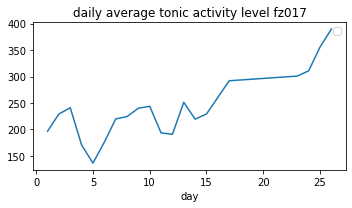

In [360]:
avg_tonic_levels= []
days = []
for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_spks = []
        daily_behav = []
        for i in iblocks:
            block = data[0, i]
            behavior = block['behavdata']
            raw_spks = block['imagingdata']
            NN, NT = raw_spks.shape
            daily_spks.append(raw_spks)
            daily_behav.append(behavior)

        daily_spks = np.hstack(daily_spks)
        daily_behav = np.hstack(daily_behav)
        daily_outcomes = daily_behav[1]
        daily_cues = daily_behav[0]

#         from scipy.stats import zscore
#         norm_spks = zscore(daily_spks, axis=1)
    
        # get the average tonic activity level before each outcome
        b, a = signal.butter(2, 0.05, 'low', analog=False)
        w, h = signal.freqs(b, a)
        avg_spks = np.mean(daily_spks, axis=0)
        tonic_spks = signal.filtfilt(b, a, avg_spks)
        avg_tonic_levels.append(np.mean(tonic_spks))
        days.append(day)
plt.figure(figsize=(5,3))
plt.plot(days, avg_tonic_levels)
plt.legend()
plt.xlabel('day')
plt.title('daily average tonic activity level {}'.format(mouse_name))
plt.tight_layout()

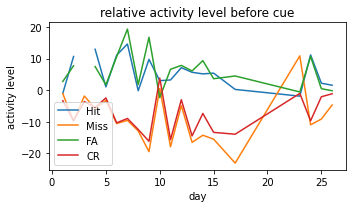

In [361]:
fig = plt.figure(figsize=(5,3))
fig.patch.set_facecolor('white')
for i in range(4):
    plt.plot(days, np.array(tonic_levels[i]) - np.array(avg_tonic_levels), label=outcome_list[i])
plt.legend()
plt.xlabel('day')
plt.ylabel('activity level')
plt.title('relative activity level before cue')
plt.tight_layout()

## 3 levels of tonic activity and stim evoke response

In [ ]:
levels = [140, 180, 220, 260]


# get daily response

In [197]:
day = 1
iblocks = daily_blocks(data, day)
daily_spks = []
daily_behav = []
for i in iblocks:
    block = data[0, i]
    behavior = block['behavdata']
    raw_spks = block['imagingdata']
    NN, NT = raw_spks.shape
    print(raw_spks.shape)
    daily_spks.append(raw_spks)
    daily_behav.append(behavior)
    
daily_spks = np.hstack(daily_spks)
print('day {} spk shape: {}'.format(day, daily_spks.shape))

daily_behav = np.hstack(daily_behav)
print('day {} behavior shape: {}'.format(day, daily_behav.shape))

from scipy.stats import zscore
norm_spks = zscore(daily_spks, axis=1)

(175, 13540)
(175, 11474)
(175, 9940)
day 1 spk shape: (175, 34954)
day 1 behavior shape: (4, 34954)
